# Accounting for the systematics in the spectral fit

In [1]:
import numpy as np
import astropy.units as u
from gammapy.utils.modeling import Parameter, ParameterList
from gammapy.spectrum.models import SpectralModel
from gammapy.spectrum import CountsPredictor, SpectrumObservationList
import matplotlib.pyplot as plt
from gammapy.stats.fit_statistics import wstat 

## Definition of a flux function with energy scale

Here we introduce a Log-Parabola modified with an energy scale factor $z$ defined as
$$
z = \frac{\tilde{E} - E}{E} = \frac{\tilde{E}}{E} - 1
$$
where $\tilde{E}$ is the observed (reconstructed) energy and $E$ is the true energy.
The differential flux we aim to fit is modified according to
$$
\frac{d\tilde{\phi}}{{d\tilde{E}}} = \frac{d \phi}{dE}(\tilde{E}) \frac{d\tilde{E}}{dE}
$$
in terms of the log-parabolic function we want to fit:
$$
\frac{d\tilde{\phi}}{{d\tilde{E}}} = \phi_0 
\left( \frac{E/(1+z)}{E_0} \right)^{-\alpha + \beta \log \left( \frac{E/(1+z)}{E_0} \right)} 
\times \left( \frac{1}{1+z}\right)
$$

In [2]:
# modified Log-Parabola formula to account for instrument energy scale
class LogParabolaEnergyScale(SpectralModel):
    """LogParabola with modified energy scale"""
    def __init__(self, 
                 amplitude=1E-12 * u.Unit('cm-2 s-1 TeV-1'), 
                 reference=1 * u.TeV,
                 alpha=3, 
                 beta=1,
                 z=0.12):
        
        self.parameters = ParameterList([
            Parameter('amplitude', amplitude),
            Parameter('reference', reference, frozen=True),
            Parameter('alpha', alpha),
            Parameter('beta', beta),
            Parameter('z', z)
        ])

    @staticmethod
    def evaluate(energy, amplitude, reference, alpha, beta, z):
        """Evaluate the model (static function)."""
        scale_factor = 1 / (1 + z)
        scaled_energy = energy * scale_factor
        try:
            xx = (scaled_energy / reference).to('')
            exponent = -alpha - beta * np.log(xx)
        except AttributeError:
            from uncertainties.unumpy import log
            xx = scaled_energy / reference
            exponent = -alpha - beta * log(xx)
        return amplitude * np.power(xx, exponent) * scale_factor

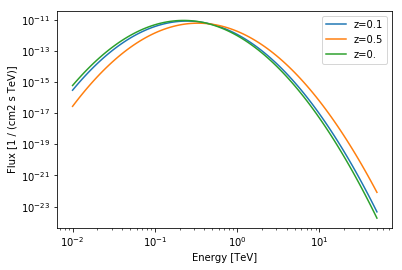

In [3]:
# let's see how the log-parabola are modified by the scale factor
logpar_1 = LogParabolaEnergyScale(z=0.1)
logpar_5 = LogParabolaEnergyScale(z=0.5)
logpar_0 = LogParabolaEnergyScale(z=0)

logpar_1.plot([0.01, 50] * u.TeV, energy_power=0, label='z=0.1')
logpar_5.plot([0.01, 50] * u.TeV, energy_power=0, label='z=0.5')
logpar_0.plot([0.01, 50] * u.TeV, energy_power=0, label='z=0.')
plt.legend()

## Define the global likelihood
To evaluate the energy scale factor per each instrument we need five different log-parabola functions sharing the spectral parameters ($\phi_0, \alpha, \beta$), but having a different energy scale factor ($z_{\rm instrument}$) each.
e.g.
$$
\frac{d\tilde{\phi}}{{d\tilde{E}}}_{\rm MAGIC} = \frac{d\tilde{\phi}}{{d\tilde{E}}}(\phi_0, \alpha, \beta, z_{\rm MAGIC})
$$
each of this function will be convolved with the instrument IRFs and used to build a Poissonian likelihood term
$$
L(\phi_0, \alpha, \beta, z_{\rm MAGIC} | N_{\rm ON\,MAGIC}, N_{\rm OFF\,MAGIC}, \alpha_{\rm MAGIC})
$$
the total (negative logarithmic) likelihood to be minimized would be then
$$
L(\phi_0, \alpha, \beta, z_{\rm Fermi}, .., z_{\rm VERITAS} | N_{\rm ON\,Fermi}, N_{\rm OFF\,Fermi}, \alpha_{\rm Fermi}, ..., N_{\rm ON\,VERITAS}, N_{\rm OFF\,VERITAS}, \alpha_{\rm VERITAS})) = 
\sum_{\rm instruments} L(\phi_0, \alpha, \beta, z_{\rm instrument} | N_{\rm ON\,instrument}, N_{\rm OFF\,instrument}, \alpha_{\rm instrument}) + \left(\frac{z_{\rm instrument}}{\delta_{\rm instrument}} \right)^2
$$
where we add a gaussian term of type $\left(\frac{z_{\rm instrument}}{\delta_{\rm instrument}} \right)^2$ for each instrument, accounting for the fact that the scale factor has to vary in a reasonable range that is determined by $\delta_{\rm instrument}$ that is what the collaboration claims about their systematic uncertainty in energy reconstruction.

Minimizing the global likelihood will return us the spectral parameters with an error that accounts for systematic and statistics uncertainties and a scaling factor $z$ per each instrument.

In [4]:
# let us read the SpectrumObservationList from the ogips, we will use them for the ON and OFF counts
# and to provide the IRFs to compute the predicted counts
spec_obs_list_fermi = SpectrumObservationList.read('../results/spectra/fermi')
spec_obs_list_magic = SpectrumObservationList.read('../results/spectra/magic')
spec_obs_list_hess = SpectrumObservationList.read('../results/spectra/hess')
spec_obs_list_veritas = SpectrumObservationList.read('../results/spectra/veritas')
spec_obs_list_fact = SpectrumObservationList.read('../results/spectra/fact')

In [5]:
def wstat_energy_scale(amplitude, alpha, beta, z, spec_obs_list):
    """single instrument log likelihood"""
    amplitude *= u.Unit('TeV-1 cm-2 s-1')

    model = LogParabolaEnergyScale(
        amplitude=amplitude,
        alpha=alpha,
        beta=beta,
        z=z
    )
    
    total_wstat = 0
    
    for spec_obs in spec_obs_list: 
        # compute predicted counts
        predictor = CountsPredictor(
            model=model, 
            aeff=spec_obs.aeff, 
            edisp=spec_obs.edisp, 
            livetime=spec_obs.livetime
        )
        predictor.run()
    
        # calculate wstat statistics per each osbervation
        _wstat = wstat(
            n_on = spec_obs.on_vector.data.data,
            n_off = spec_obs.off_vector.data.data,
            alpha = spec_obs.alpha,
            mu_sig = predictor.npred.data.data
        )
    
        _wstat = np.sum(_wstat)
        total_wstat += _wstat
    
    return total_wstat

In [6]:
def all_instrument_wstat(amplitude, alpha, beta, z_fermi, z_magic, z_hess, z_veritas, z_fact):
    """sum of all the instrument likelihoods with log-parabola w/ energy scale correction"""
    all_instrument_wstat = (
        wstat_energy_scale(amplitude, alpha, beta, z_fermi, spec_obs_list_fermi) +
        wstat_energy_scale(amplitude, alpha, beta, z_magic, spec_obs_list_magic) +
        wstat_energy_scale(amplitude, alpha, beta, z_hess, spec_obs_list_hess) +
        wstat_energy_scale(amplitude, alpha, beta, z_veritas, spec_obs_list_veritas) +
        wstat_energy_scale(amplitude, alpha, beta, z_fact, spec_obs_list_fact) +
        ((z_fermi/0.10)**2 + (z_magic/0.15)**2 + (z_hess/0.15)**2 + (z_veritas/0.15)**2 + (z_fact/0.20)**2)
    )
    return all_instrument_wstat

In [7]:
# minimize the likelihood
from iminuit import Minuit

m = Minuit(
    all_instrument_wstat,
    
    amplitude=3e-12,
    alpha=2.4,
    beta=0.2,
    z_fermi=0.1,
    z_magic=0.1,
    z_hess=0.1,
    z_veritas=0.1,
    z_fact=0.1,
    
    error_amplitude=1e-13,
    error_alpha=0.01,
    error_beta=0.001,
    error_z_fermi=0.001,
    error_z_magic=0.001,
    error_z_hess=0.001,
    error_z_veritas=0.001,
    error_z_fact=0.001,
    
    limit_amplitude=(1e-15,1e-9),
    limit_z_fermi=(-0.3,0.3),
    limit_z_magic=(-0.3,0.3),
    limit_z_hess=(-0.3,0.3),
    limit_z_veritas=(-0.3,0.3),
    limit_z_fact=(-0.3,0.3),
)

m.migrad()

/home/cosimo/software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: InitialParamWarning: errordef is not given. Default to 1.


FCN = 458.849173363093 
 TOTAL NCALL = 375 
 NCALLS = 375 
 
 
 EDM = 8.201916954027893e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,amplitude,3.93317e-11,4.09495e-12,,,1e-15,1e-09,No
1,alpha,2.48857,0.0347403,,,,,No
2,beta,0.100721,0.010556,,,,,No
3,z_fermi,0.0147057,0.0723921,,,-0.3,0.3,No
4,z_magic,-9.60344e-05,0.0704607,,,-0.3,0.3,No
5,z_hess,0.0974048,0.0786904,,,-0.3,0.3,No
6,z_veritas,-0.0801727,0.0699965,,,-0.3,0.3,No
7,z_fact,-0.137091,0.0698792,,,-0.3,0.3,No


({'fval': 458.849173363093,
  'edm': 8.201916954027893e-05,
  'nfcn': 375,
  'up': 1.0,
  'is_valid': True,
  'has_valid_parameters': True,
  'has_accurate_covar': True,
  'has_posdef_covar': True,
  'has_made_posdef_covar': False,
  'hesse_failed': False,
  'has_covariance': True,
  'is_above_max_edm': False,
  'has_reached_call_limit': False},
 [{'number': 0,
   'name': 'amplitude',
   'value': 3.9331701566988755e-11,
   'error': 4.0949474525968885e-12,
   'is_const': False,
   'is_fixed': False,
   'has_limits': True,
   'has_lower_limit': True,
   'has_upper_limit': True,
   'lower_limit': 1e-15,
   'upper_limit': 1e-09},
  {'number': 1,
   'name': 'alpha',
   'value': 2.488570144043279,
   'error': 0.03474025159275515,
   'is_const': False,
   'is_fixed': False,
   'has_limits': False,
   'has_lower_limit': False,
   'has_upper_limit': False,
   'lower_limit': None,
   'upper_limit': None},
  {'number': 2,
   'name': 'beta',
   'value': 0.10072147318577178,
   'error': 0.010556008

In [8]:
m.hesse()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,amplitude,3.93317e-11,4.09499e-12,,,1e-15,1e-09,No
1,alpha,2.48857,0.0347404,,,,,No
2,beta,0.100721,0.010556,,,,,No
3,z_fermi,0.0147057,0.0723923,,,-0.3,0.3,No
4,z_magic,-9.60344e-05,0.0704612,,,-0.3,0.3,No
5,z_hess,0.0974048,0.0786912,,,-0.3,0.3,No
6,z_veritas,-0.0801727,0.069997,,,-0.3,0.3,No
7,z_fact,-0.137091,0.0698799,,,-0.3,0.3,No


+,amplitude,alpha,beta,z_fermi,z_magic,z_hess,z_veritas,z_fact
amplitude,1.00,-0.51,0.14,-0.59,-0.86,-0.92,-0.81,-0.84
alpha,-0.51,1.00,0.58,0.10,0.31,0.56,0.34,0.63
beta,0.14,0.58,1.00,0.09,-0.13,-0.02,-0.13,0.10
z_fermi,-0.59,0.10,0.09,1.00,0.64,0.54,0.54,0.48
z_magic,-0.86,0.31,-0.13,0.64,1.00,0.78,0.73,0.70
z_hess,-0.92,0.56,-0.02,0.54,0.78,1.00,0.74,0.80
z_veritas,-0.81,0.34,-0.13,0.54,0.73,0.74,1.00,0.67
z_fact,-0.84,0.63,0.10,0.48,0.70,0.80,0.67,1.00


[{'number': 0,
  'name': 'amplitude',
  'value': 3.9331701566988755e-11,
  'error': 4.094992211532874e-12,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': True,
  'lower_limit': 1e-15,
  'upper_limit': 1e-09},
 {'number': 1,
  'name': 'alpha',
  'value': 2.488570144043279,
  'error': 0.03474042983688921,
  'is_const': False,
  'is_fixed': False,
  'has_limits': False,
  'has_lower_limit': False,
  'has_upper_limit': False,
  'lower_limit': None,
  'upper_limit': None},
 {'number': 2,
  'name': 'beta',
  'value': 0.10072147318577178,
  'error': 0.010555991962184444,
  'is_const': False,
  'is_fixed': False,
  'has_limits': False,
  'has_lower_limit': False,
  'has_upper_limit': False,
  'lower_limit': None,
  'upper_limit': None},
 {'number': 3,
  'name': 'z_fermi',
  'value': 0.014705711704696534,
  'error': 0.07239229389479737,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'h

In [9]:
m.minos()

Error,-3.8168971070529175e-12,4.404612571786455e-12
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.034143569299130205,0.035424807246116206
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.010495904311133095,0.010656892777265899
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0722639461355569,0.07398913933893687
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.07025001485691941,0.07193017616736413
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.07866521287531983,0.08073416043369147
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.06952391847172064,0.07176729694542192
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.06926917139281262,0.07193383089595709
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'amplitude': {'lower': -3.8168971070529175e-12,
  'upper': 4.404612571786455e-12,
  'is_valid': True,
  'lower_valid': True,
  'upper_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 257,
  'min': 3.9331701566988755e-11},
 'alpha': {'lower': -0.034143569299130205,
  'upper': 0.035424807246116206,
  'is_valid': True,
  'lower_valid': True,
  'upper_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 208,
  'min': 2.488570144043279},
 'beta': {'lower': -0.010495904311133095,
  'upper': 0.010656892777265899,
  'is_valid': True,
  'lower_valid': True,
  'upper_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_

Here we plot the $\tilde{E}/E$ values per each instrument, figure inspired by right panel of Figure 3 in 
https://arxiv.org/abs/1711.11432

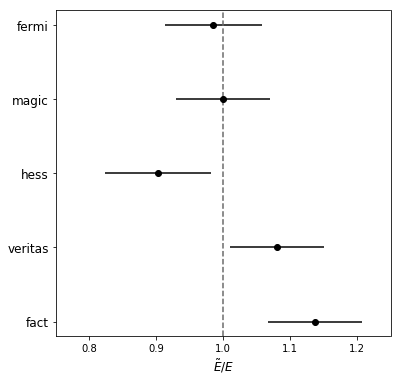

In [10]:
z_fermi = m.values['z_fermi']
z_fermi_err = m.errors['z_fermi']

z_magic = m.values['z_magic']
z_magic_err = m.errors['z_magic']

z_hess = m.values['z_hess']
z_hess_err = m.errors['z_hess']

z_veritas = m.values['z_veritas']
z_veritas_err = m.errors['z_veritas']

z_fact = m.values['z_fact']
z_fact_err = m.errors['z_fact']

fig, ax = plt.subplots(figsize=(6,6,))
ax.errorbar(y=1, x=1-z_fact, xerr=z_fact_err, marker='o', ls='', color='k')
ax.errorbar(y=2, x=1-z_veritas, xerr=z_veritas_err, marker='o', ls='', color='k')
ax.errorbar(y=3, x=1-z_hess, xerr=z_hess_err, marker='o', ls='', color='k')
ax.errorbar(y=4, x=1-z_magic, xerr=z_magic_err, marker='o', ls='', color='k')
ax.errorbar(y=5, x=1-z_fermi, xerr=z_fermi_err, marker='o', ls='', color='k')

ax.set_yticks([1,2,3,4,5])    
ax.set_yticklabels(['fact', 'veritas', 'hess', 'magic', 'fermi'], fontsize=12)
ax.axvline(1, ls='--', color='dimgrey', lw=1.5)
ax.set_xlabel(r'$\tilde{E}/E$', fontsize=12)
ax.set_xlim([0.75,1.25])
fig.savefig('../results/figures/syst_error/scaling_factors_systematics.png')